In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

In [36]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5_wgs84_SnapR.tif' # desktop
gt_image_05 = '../../rasters/union_impervious_raster_0_5_wgs84_noSnapR.tif' # desktop

# specify the shapefile
shpfile = '../../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

1

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt, window_size=64)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt, window_size=64)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC3(src, samp_pt) for samp_pt in lonlat_PAN]




In [9]:
# image transform for DG imagery. Top is 8 band MS, lower is 4 band Pansharped 
# img_transform = Compose([
#     Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
#               std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
# ])

img_transform = Compose([
    Normalize(mean=[1454.3645, 1346.8903, 1333.2897, 1319.6912], 
              std=[461.94232, 552.4788, 591.1144, 661.6691])
])

In [10]:
# for i in range(4):
#     print(image_05m[i,1000:5000,1000:5000].mean().compute(), image_05m[i,1000:5000,1000:5000].std().compute())
# image_05m.shape

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [11]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [37]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_05, coords_pan[:train_ind], transform=gt_transform, window_size=64) 
# gt_dataset_train = gtDatasetSampler2(gt_image_05, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_05, coords_pan[train_ind:val_ind], transform=gt_transform, window_size=64)
gt_dataset_test = gtDatasetSampler2(gt_image_05, coords_pan[val_ind:], transform=gt_transform, window_size=64)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(image_05m, coords_pan[:train_ind], transform=img_transform, comb='bgrn', window_size=64) # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(image_05m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(image_05m, coords_pan[train_ind:val_ind], transform=img_transform, comb='bgrn',window_size=64)
dg_dataset_test = DigitalGlobeSamplerTensor(image_05m, coords_pan[val_ind:], transform=img_transform, comb='bgrn', window_size=64)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [13]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [14]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [15]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

## TRY A LOCAL IMPLEMENTATION OF UNET

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [43]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

## call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model_c = unet11_MS(pretrained=False, num_bands=4)
# model_c = UNet(in_channels=4, n_classes=1, padding=True)

# set some parameters
lr = 0.0001
optimizer = Adam(model_c.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     #model = nn.DataParallel(model)
    
# model.to(device)


# above doesn't work until 0.4.1
# model.cuda()


print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)


# record time for one epoch
t0 = time.time()
for epoch in range(100):
    
    try:
        te = time.time()

        epoch_i = epoch+1
        print('on epoch {}'.format(epoch_i))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        for i, (inputs_, targets_) in enumerate(tl):

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = Variable(inputs_), Variable(targets_)
            #inputs.to(device)
            #targets.to(device)

            outputs = model_c(inputs)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1


            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.data.numpy().squeeze().flatten()
            target_y = targets.data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

        losses_ep.append(losses)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

    except Exception as e:
        print('something happened')
        tb = sys.exc_info()[2]
        e.with_traceback(tb)
        print(e)
        break
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

num_bands is  4
batchsize,  8
training...
on epoch 1


KeyboardInterrupt: 

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [ ]:
model.eval()

In [ ]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





In [ ]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

In [ ]:
plt.plot(all_thresh[0])

In [ ]:
model_path = 'runs/debug/Pansharpened_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

In [ ]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])

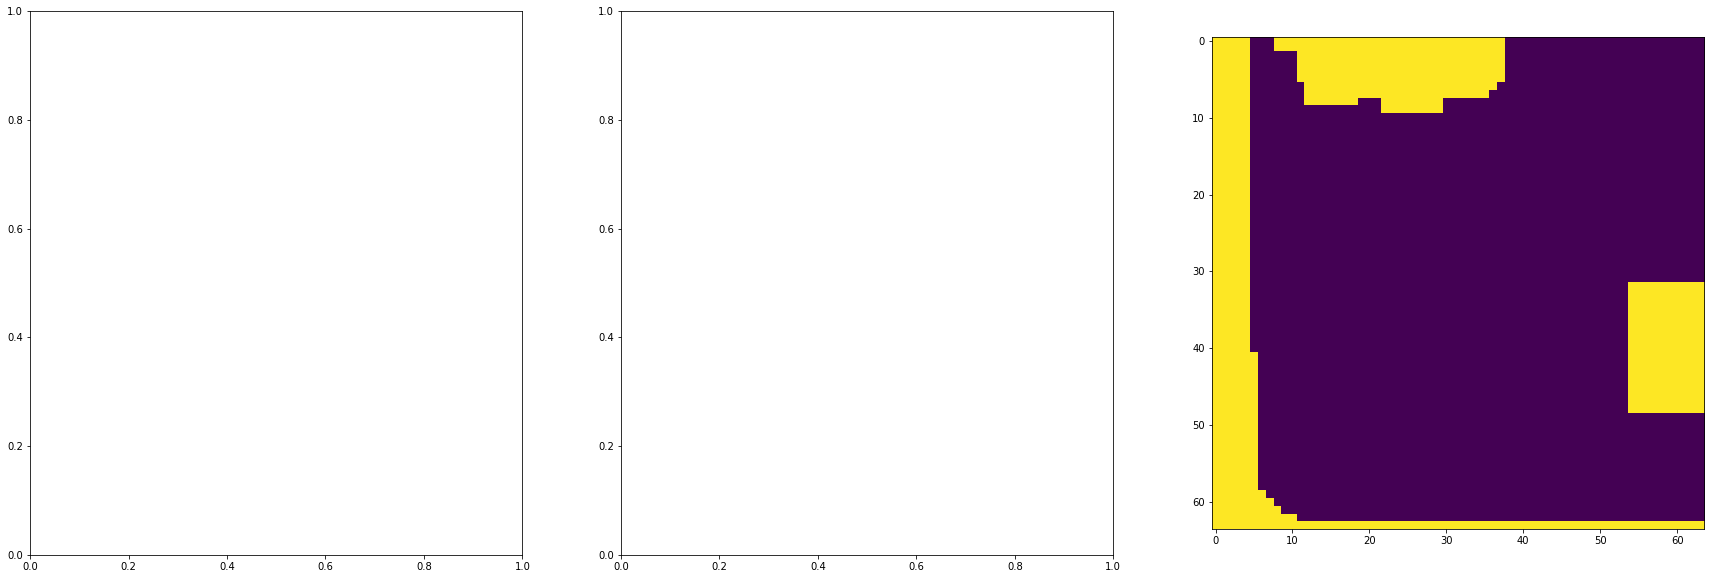

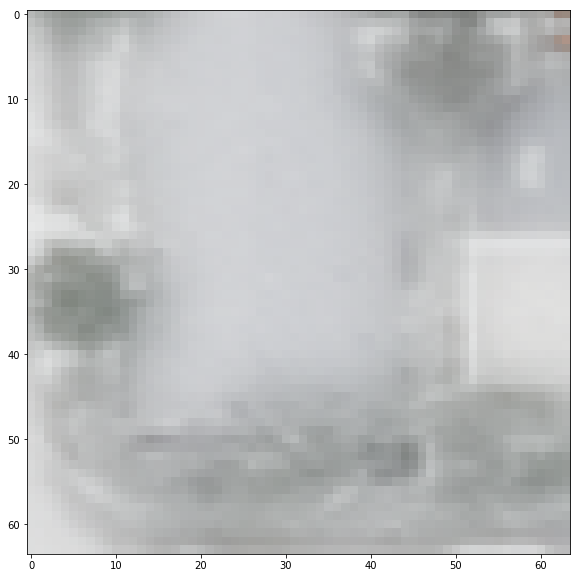

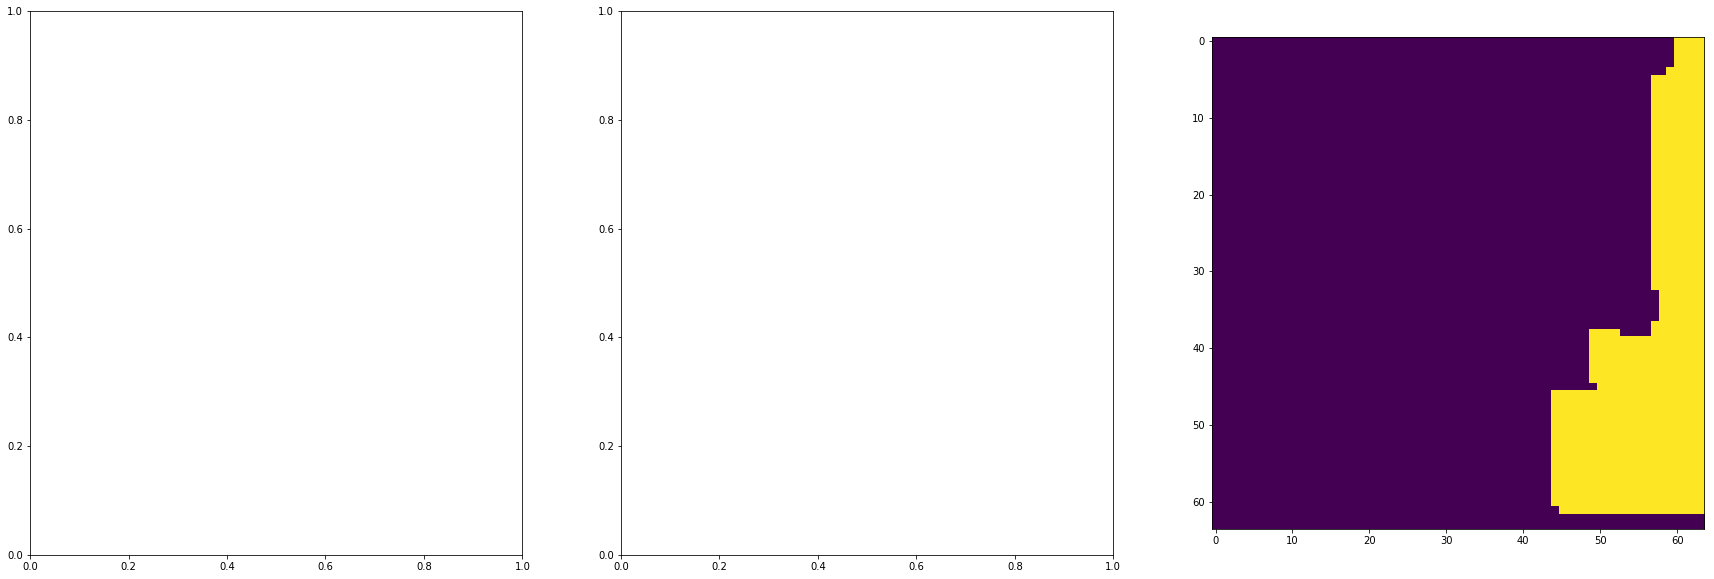

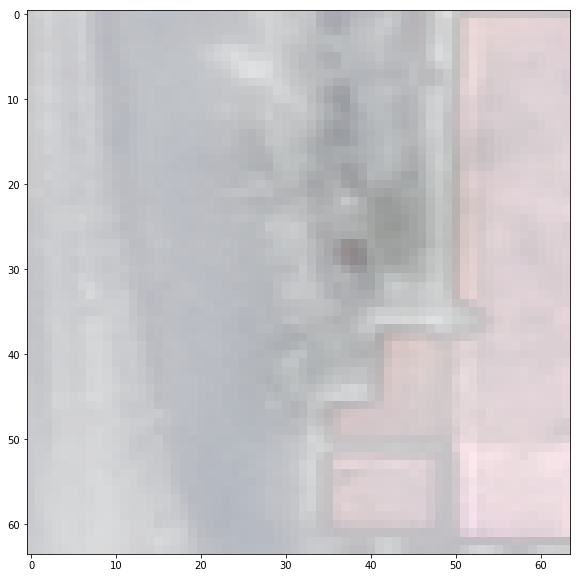

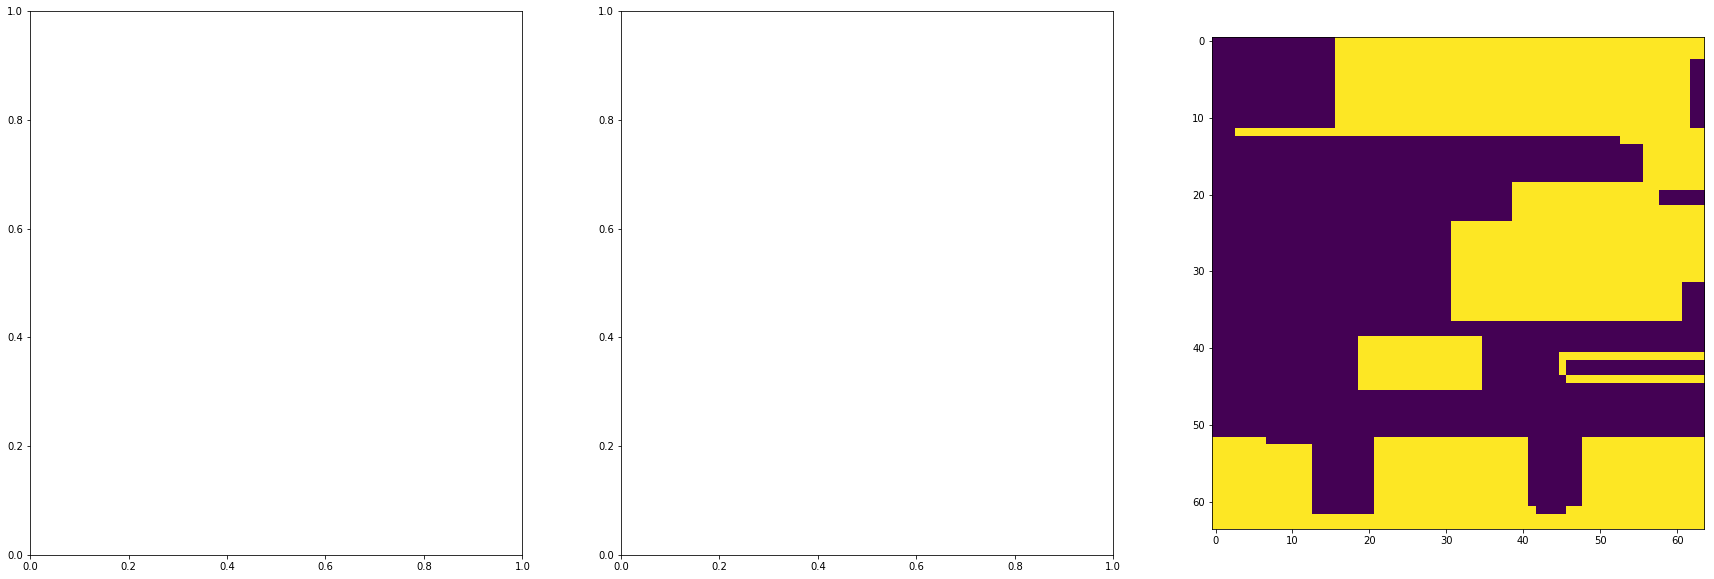

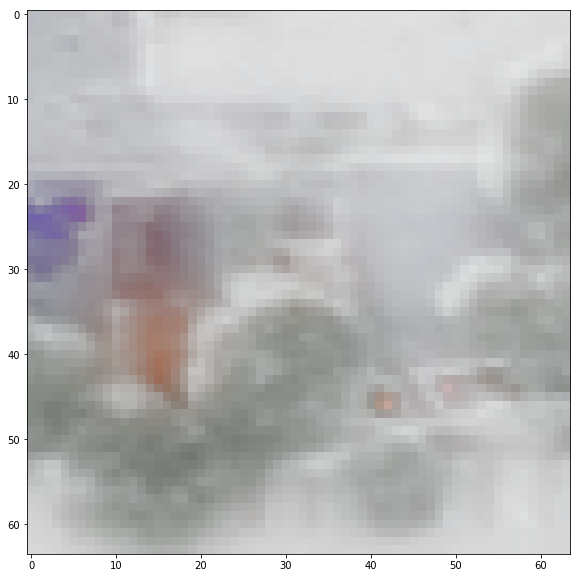

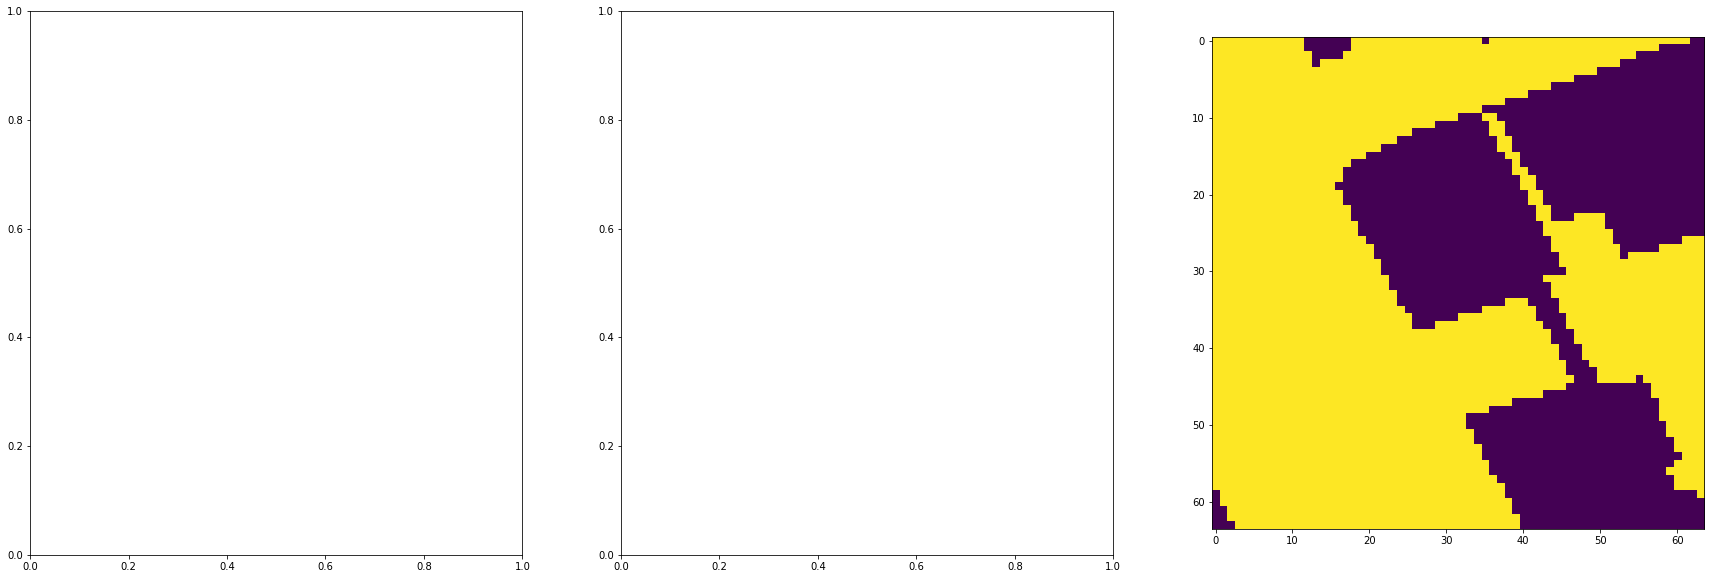

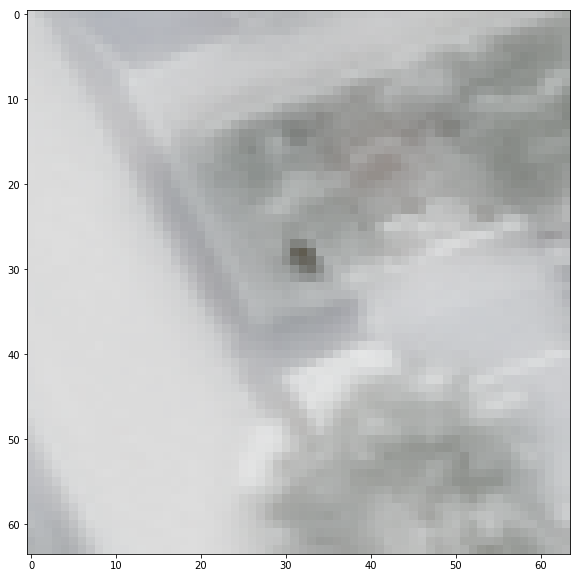

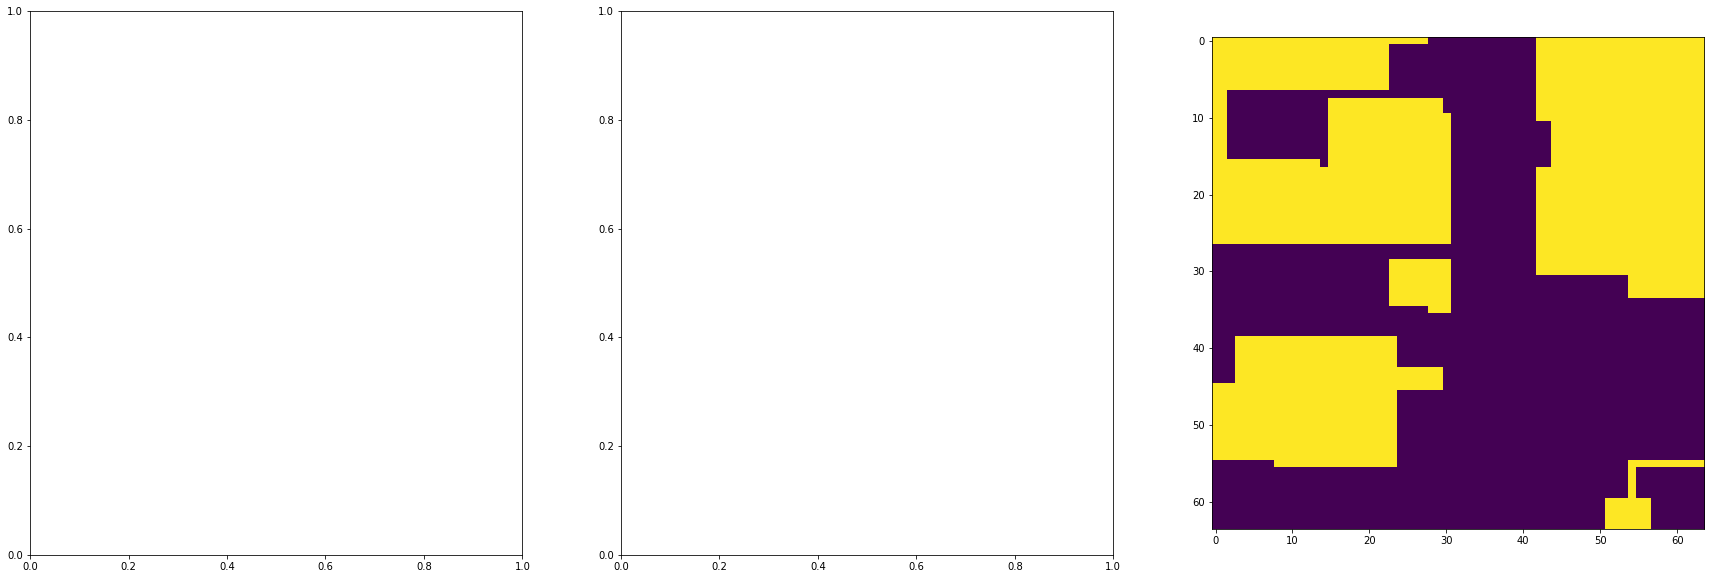

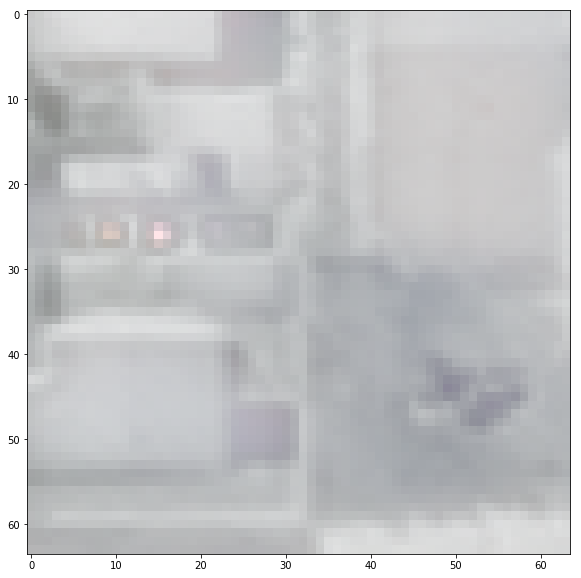

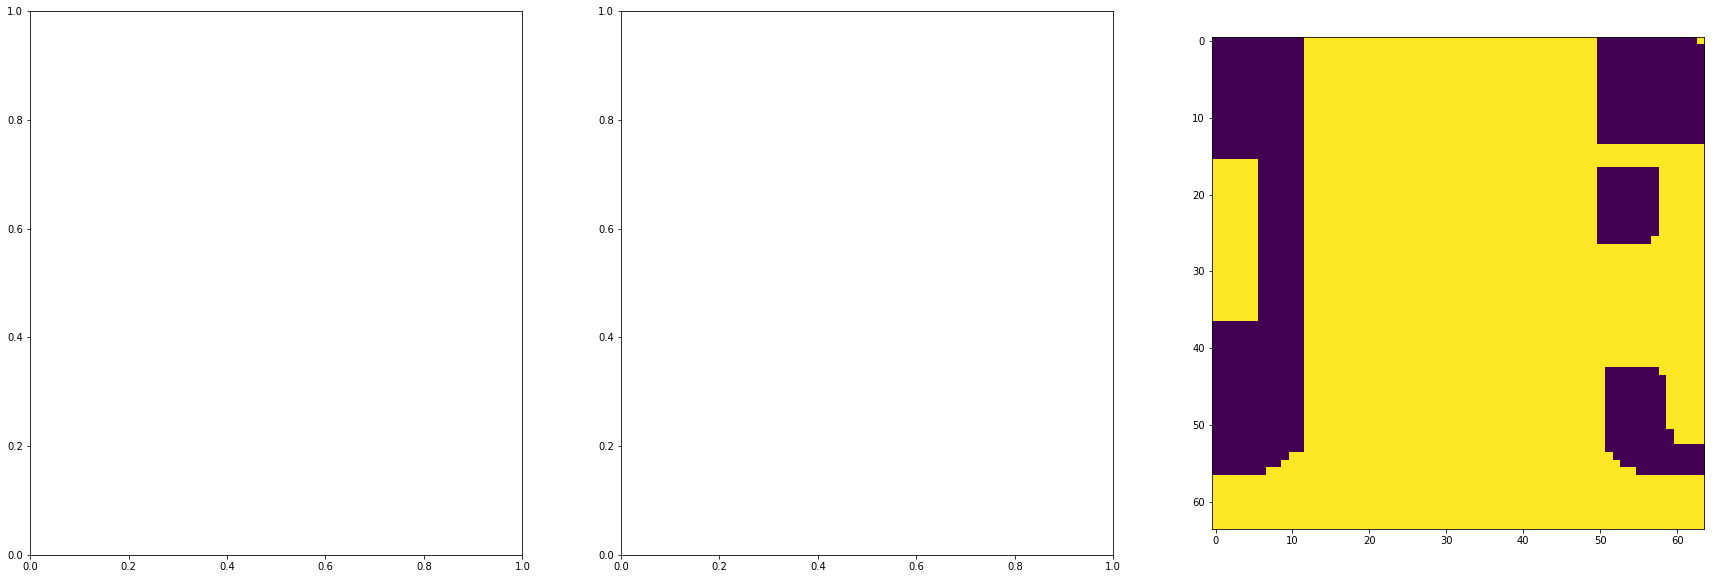

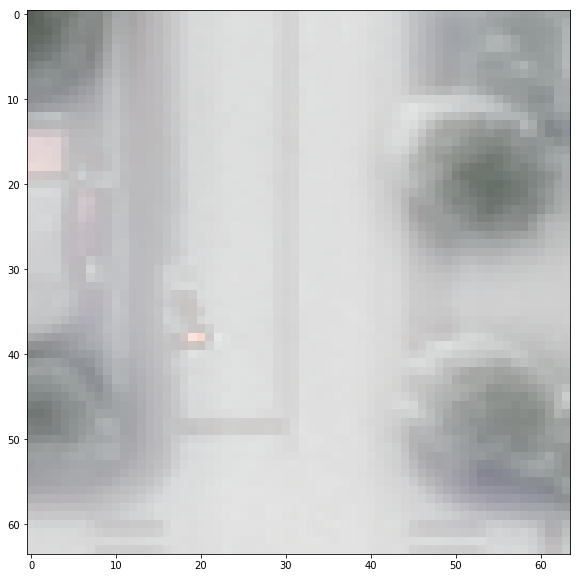

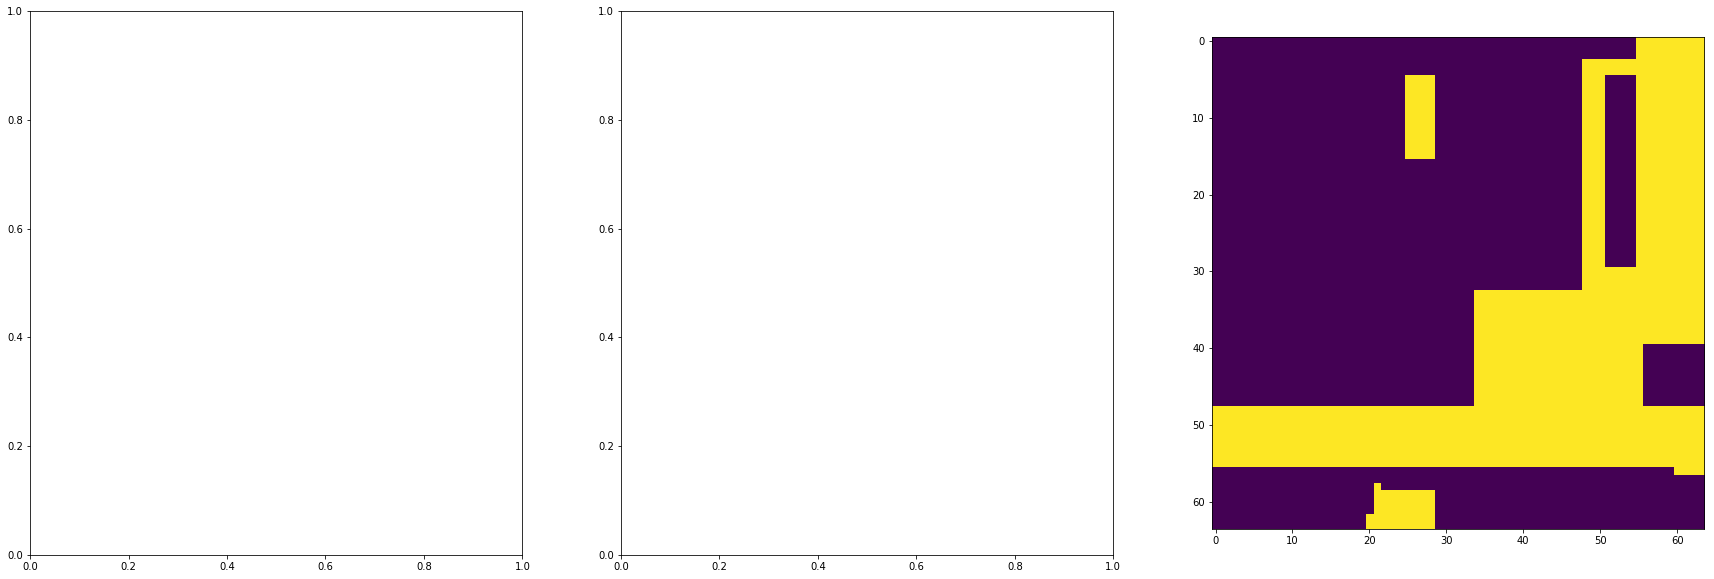

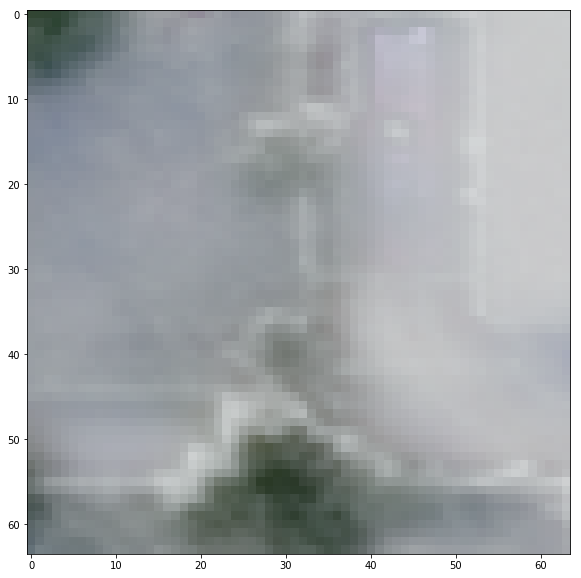

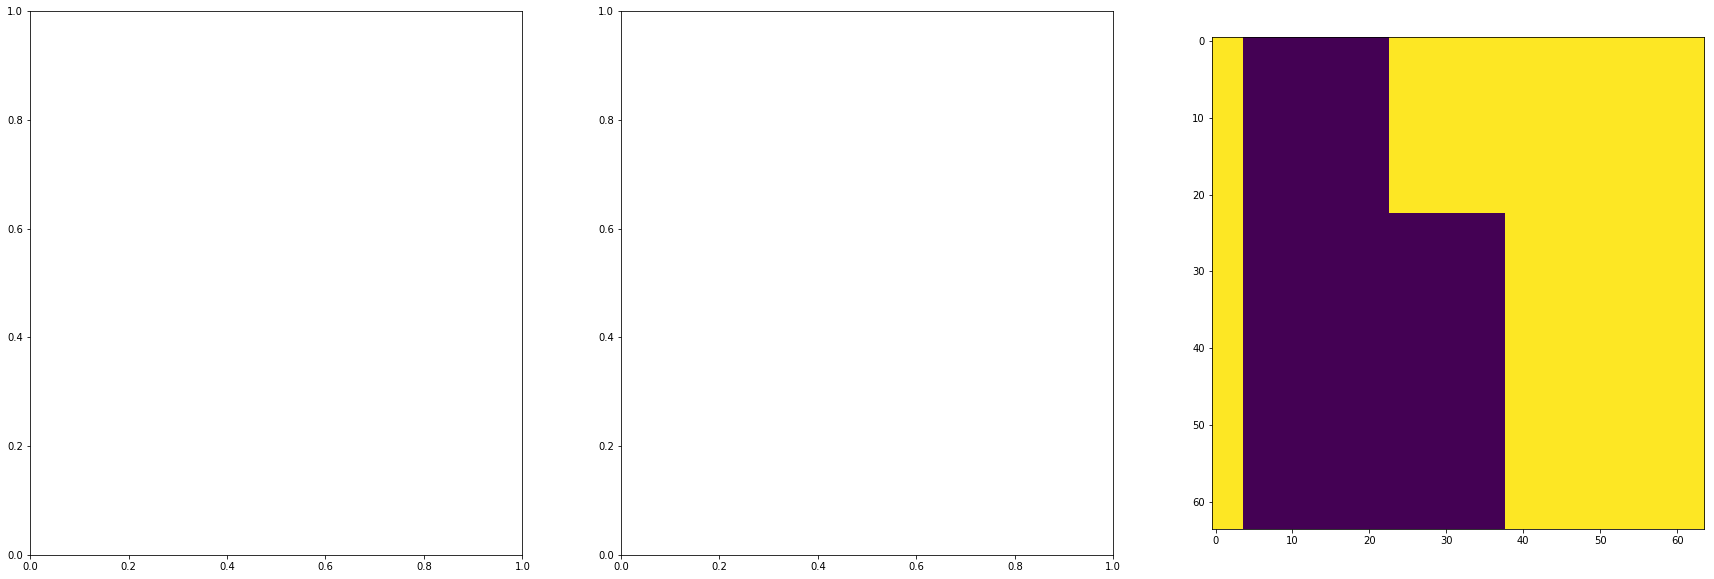

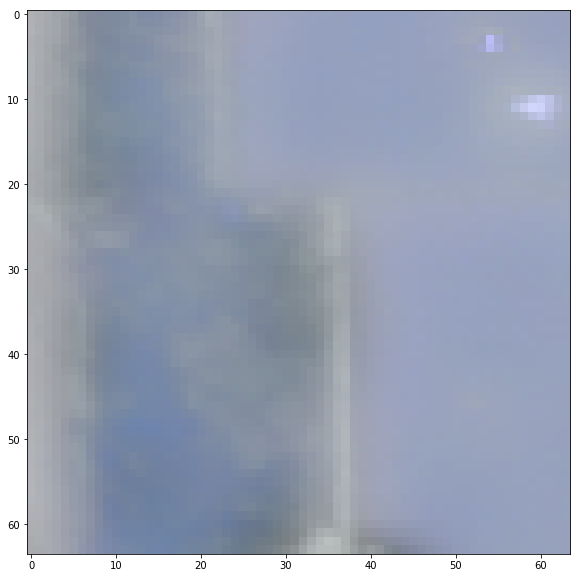

KeyboardInterrupt: 

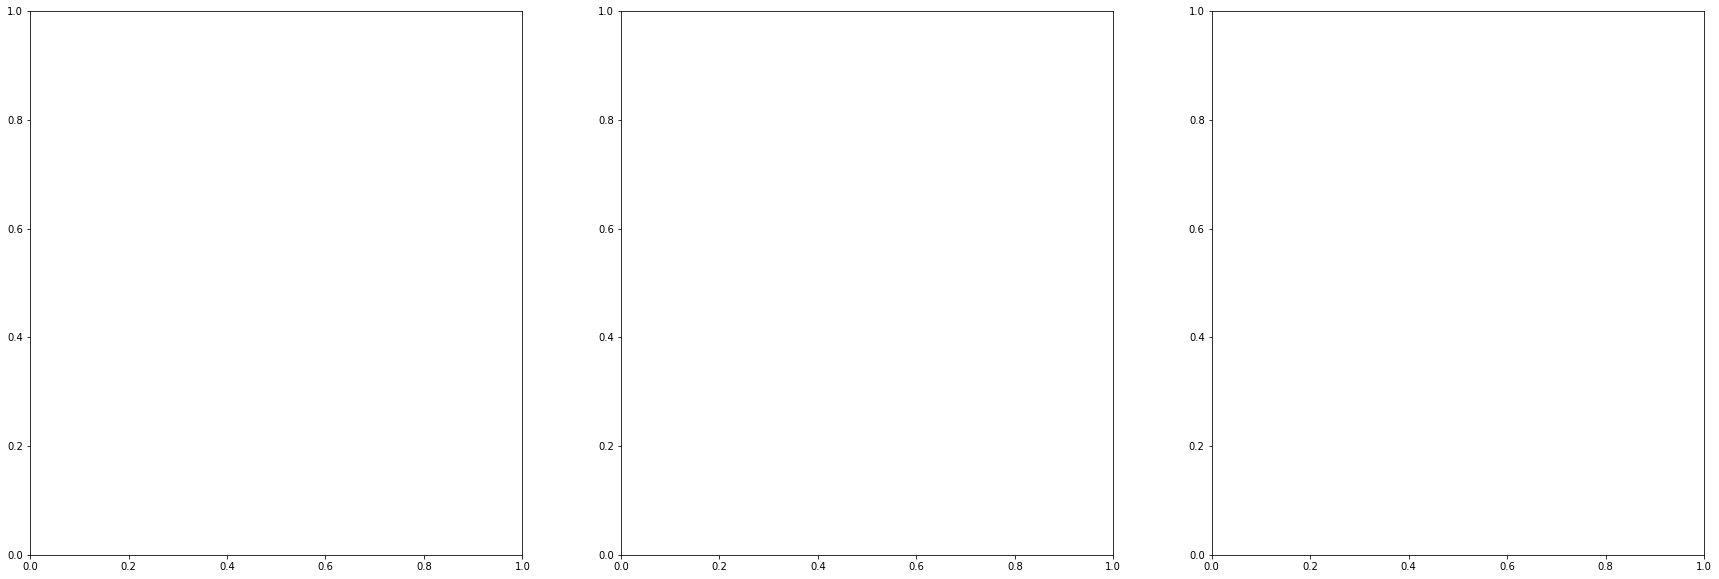

In [30]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
    mask = model(input_img)


    mask_im = mask.squeeze().data.cpu().numpy()
    mask_binary = mask_im.copy()

    fig, ax = plt.subplots(1,3, figsize=(30,10))
    thresh = 0
    mask_binary[mask_im<=thresh] = 0
    mask_binary[mask_im>thresh] = 1
    ax[0].imshow(mask_binary)
    # ax[0].colorbar()
    ax[1].imshow(mask_im)
    gt_im = gt_dataset_test[test_ind].numpy().squeeze()
    ax[2].imshow(gt_im)
    # ax[1].colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    source_im = dg_dataset_test[test_ind].numpy()
    plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
    plt.show()



In [ ]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [ ]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [ ]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))

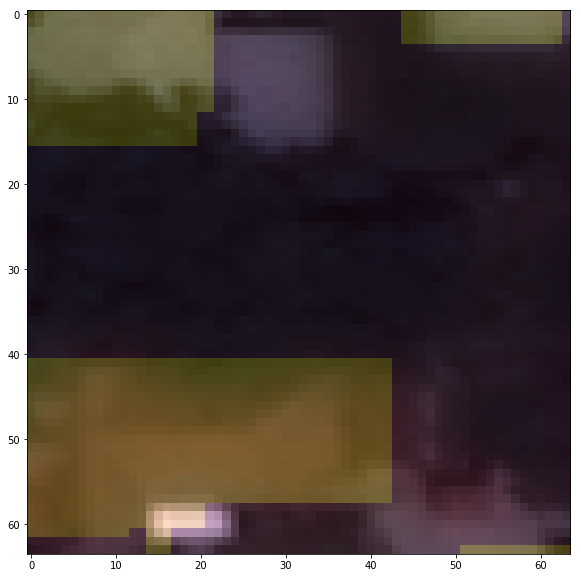

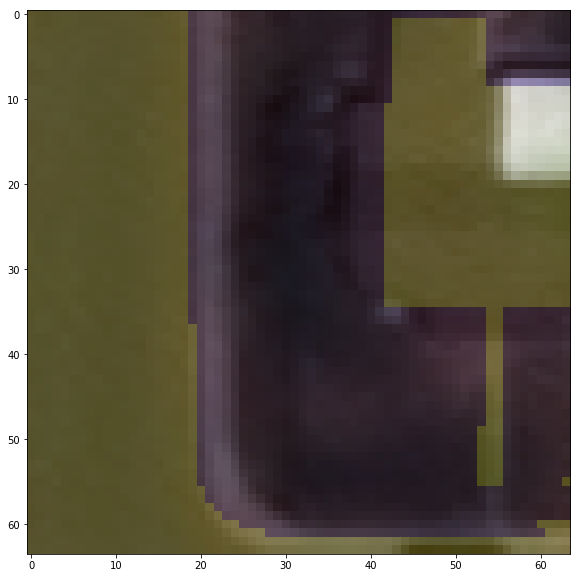

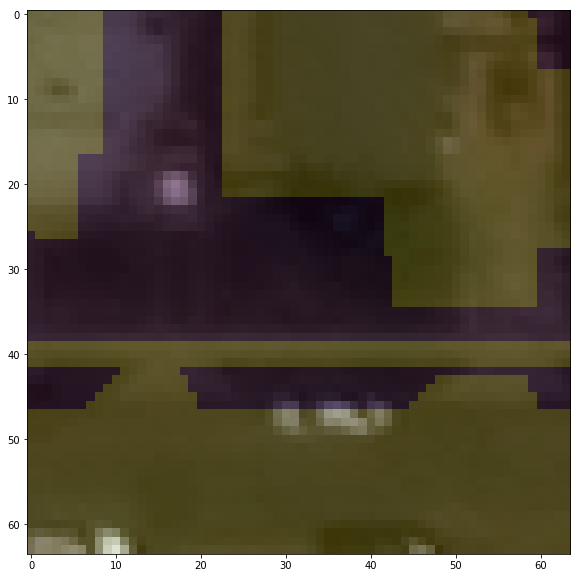

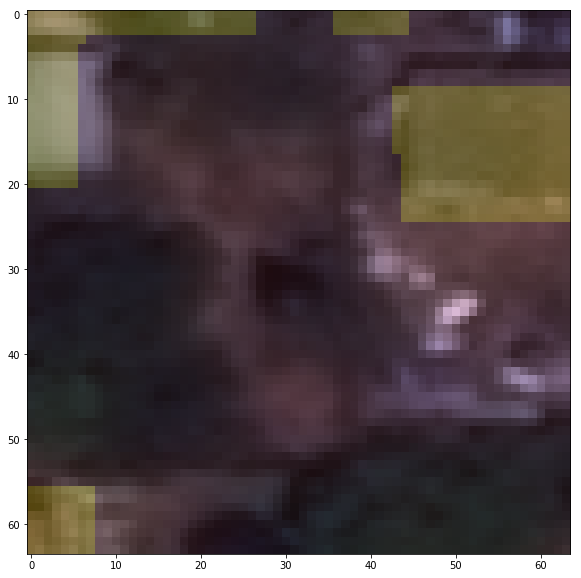

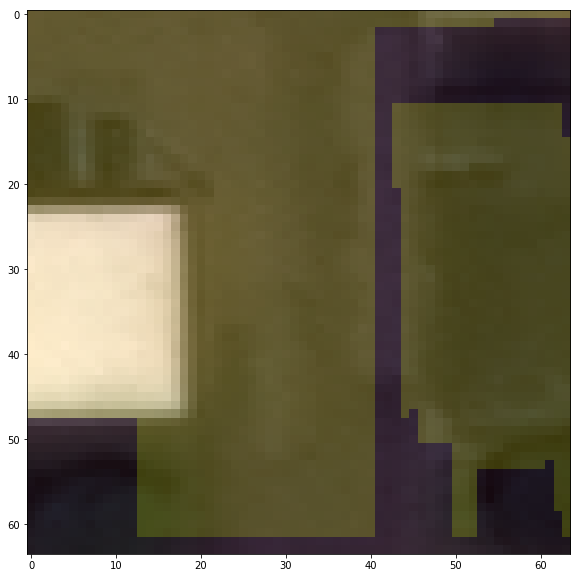

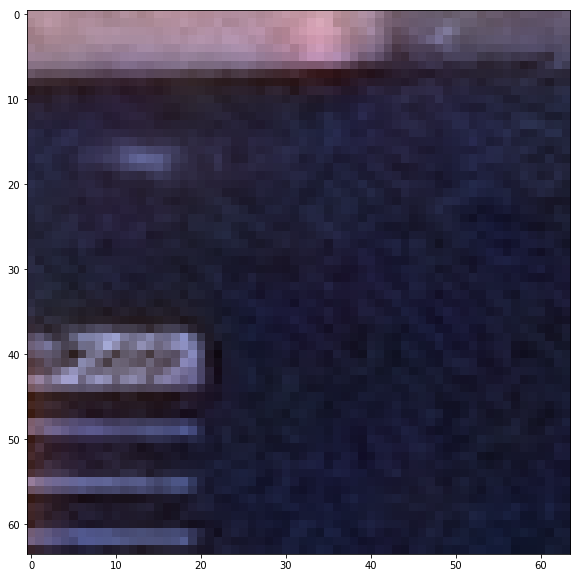

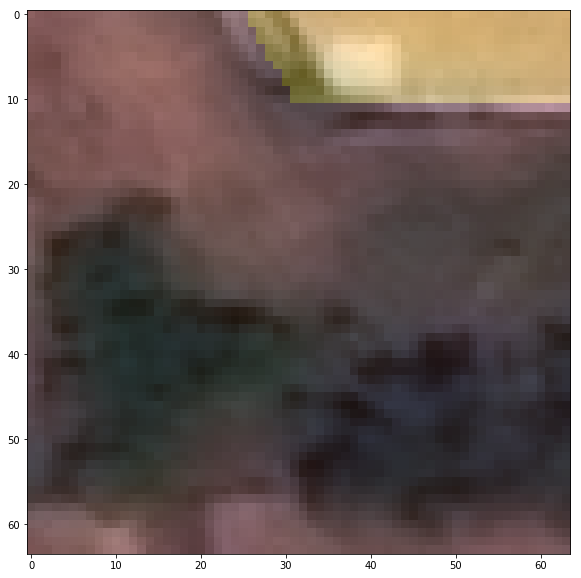

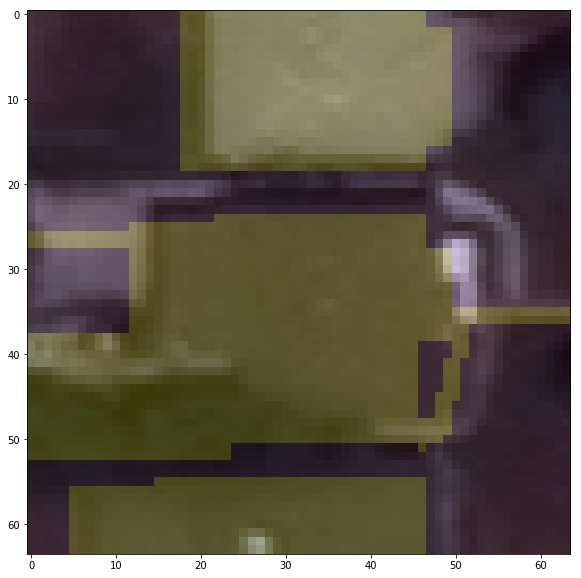

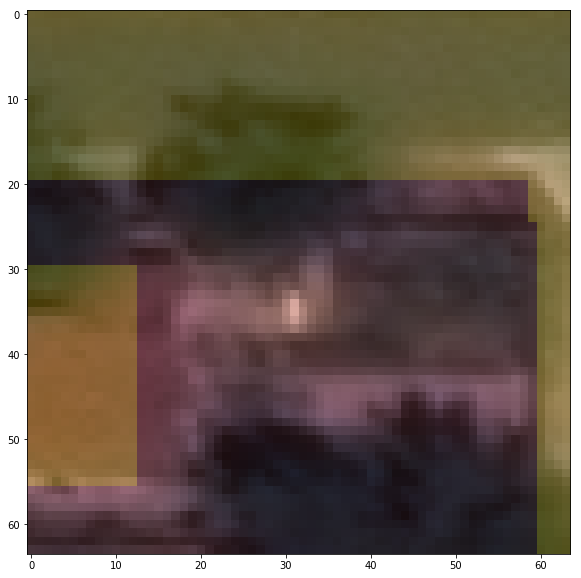

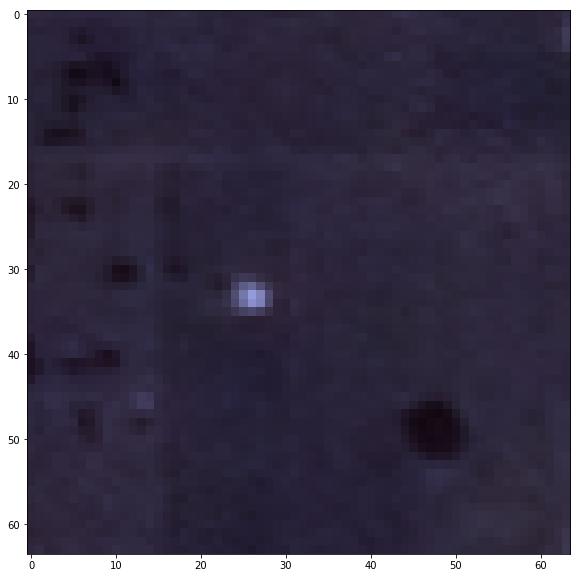

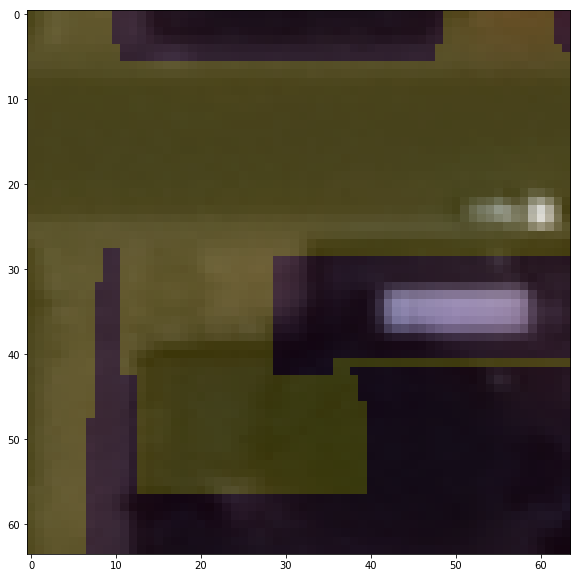

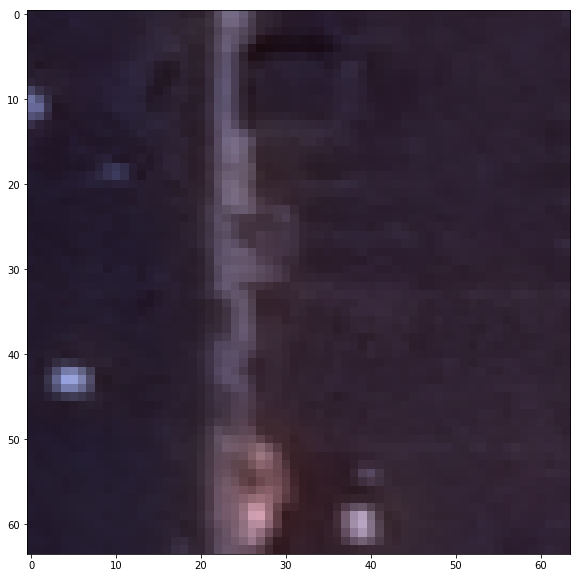

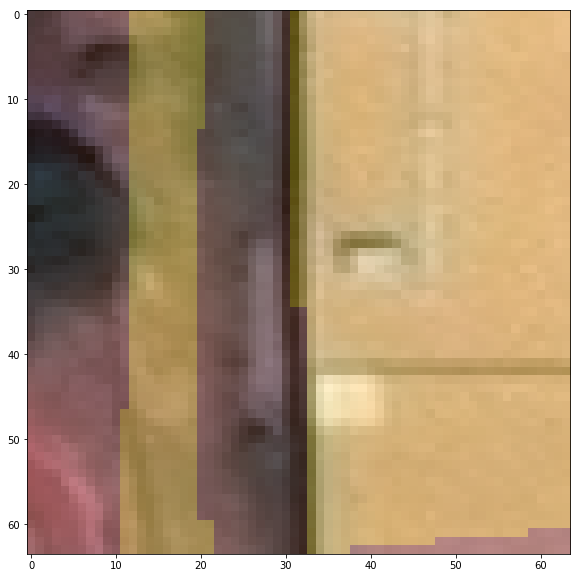

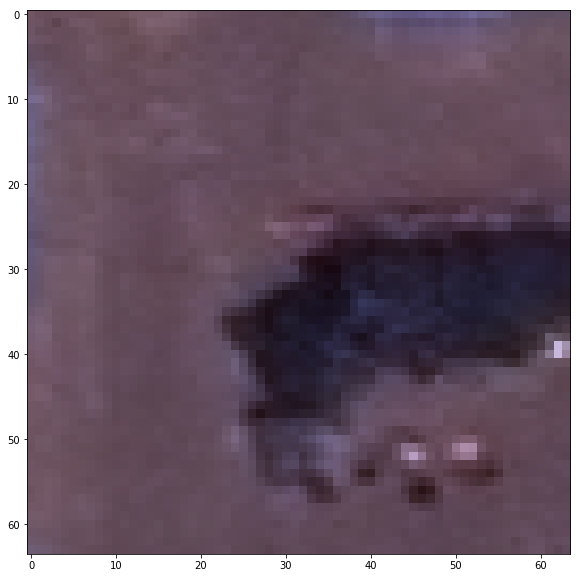

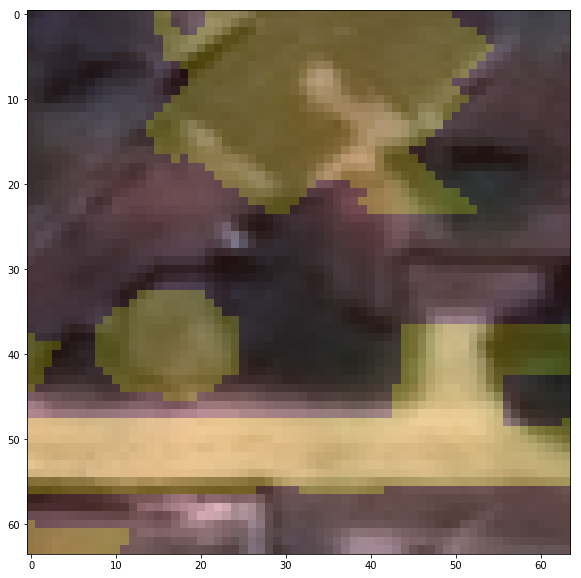

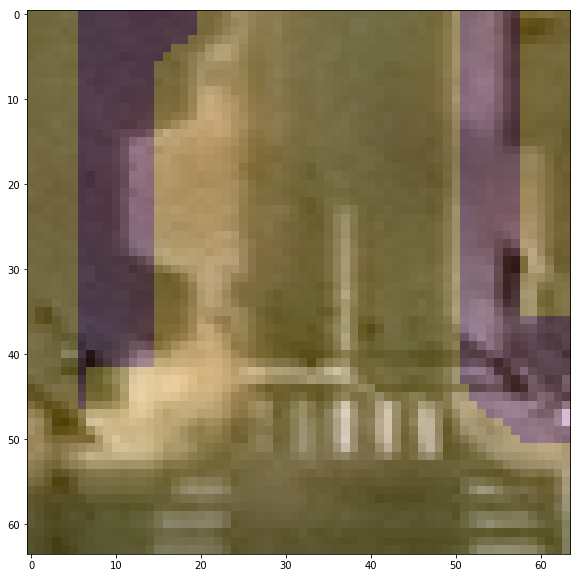

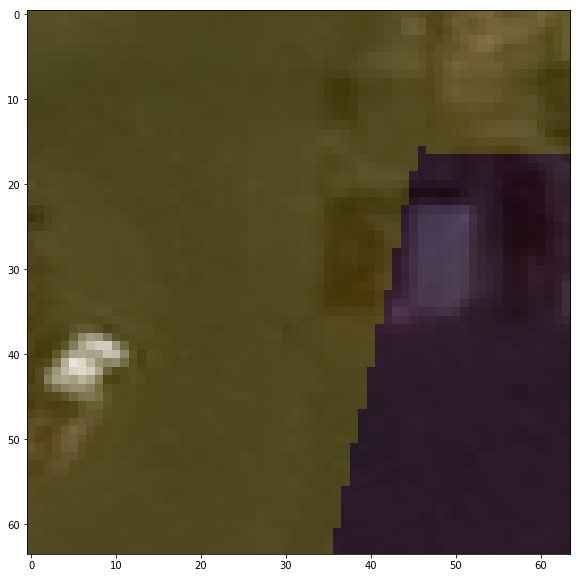

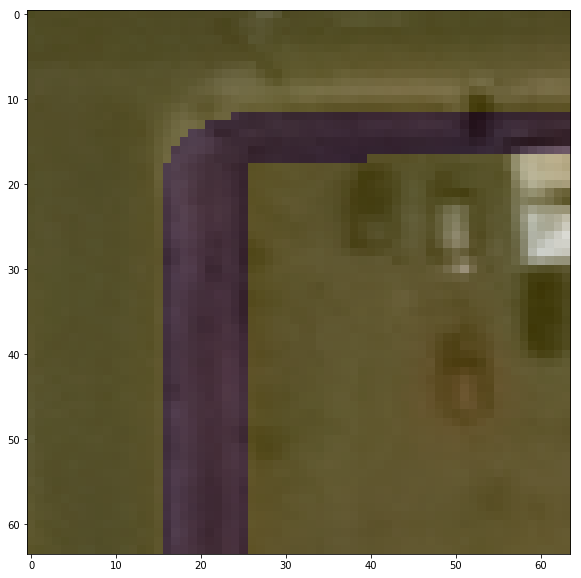

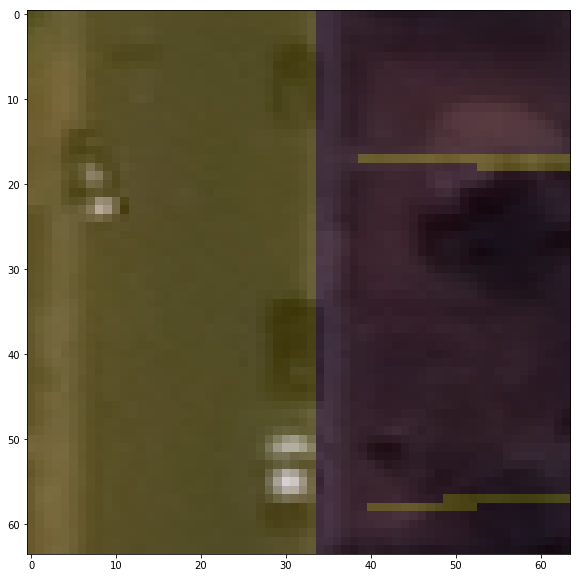

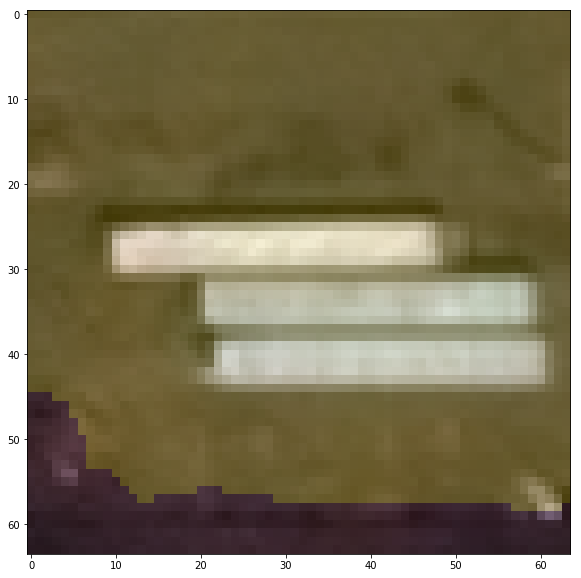

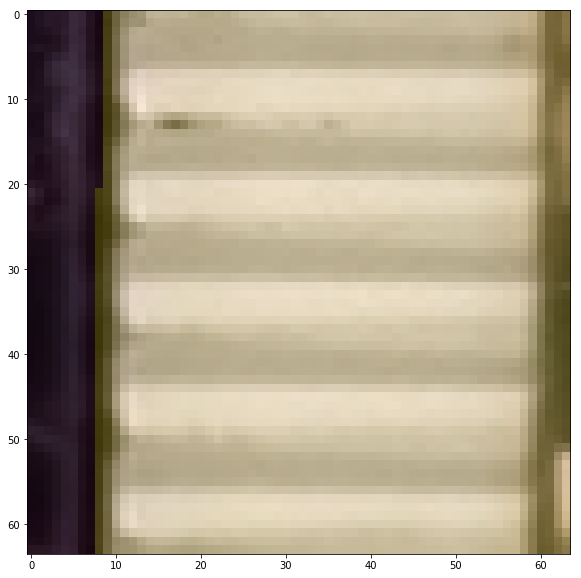

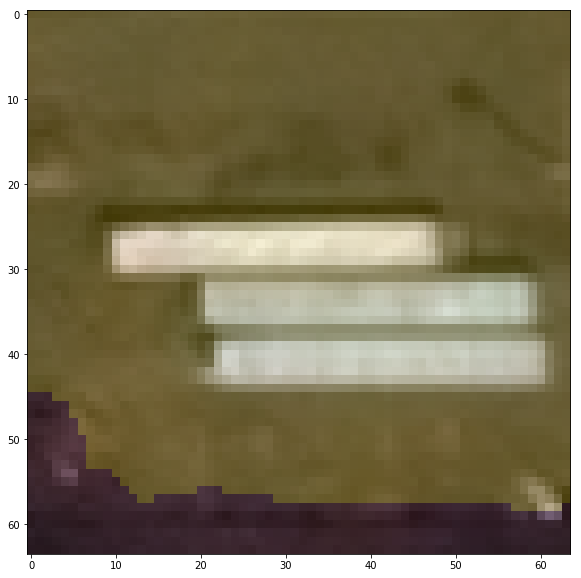

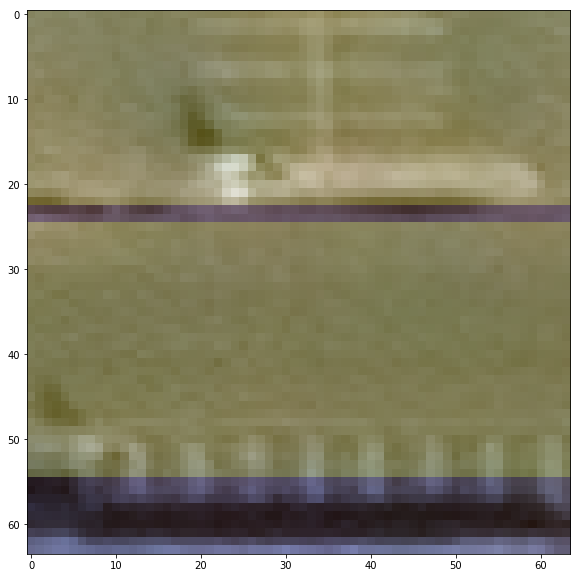

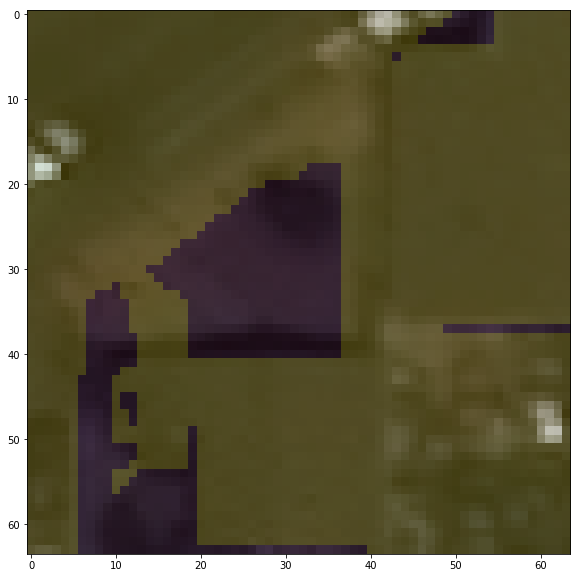

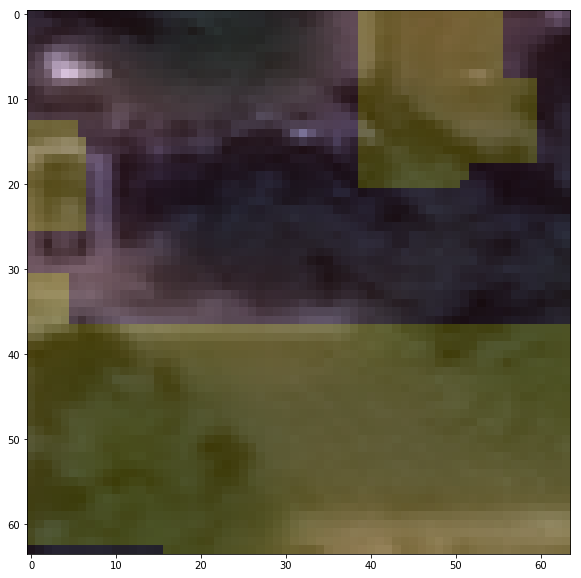

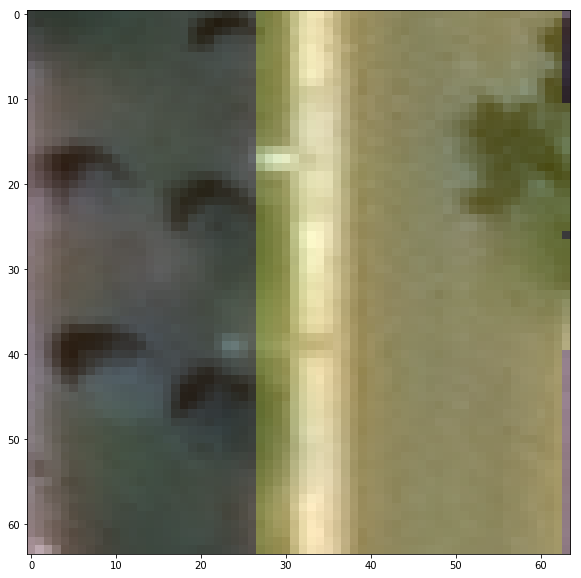

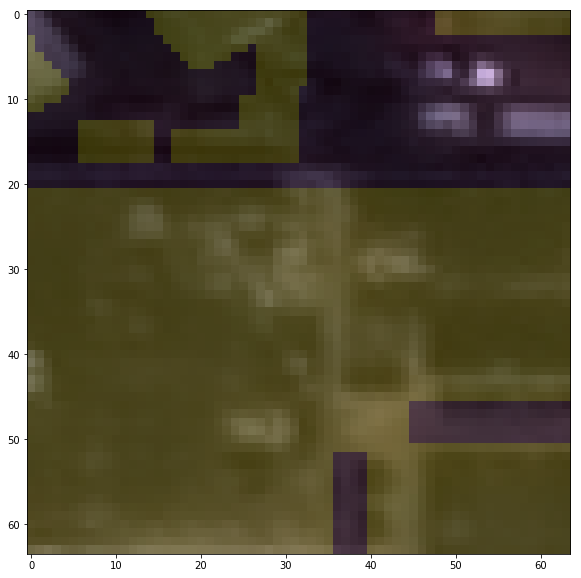

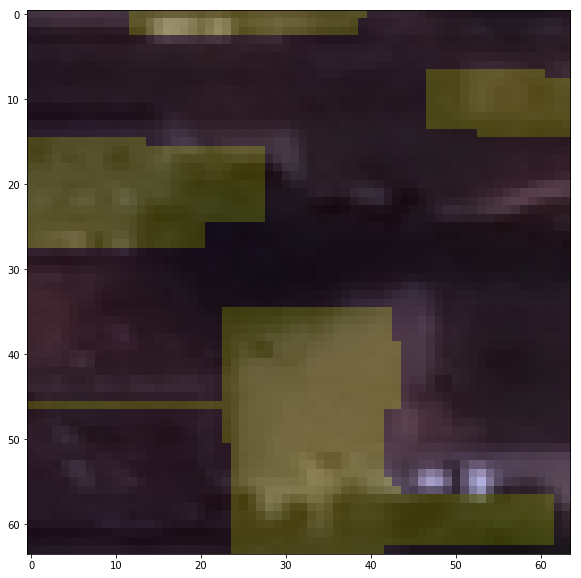

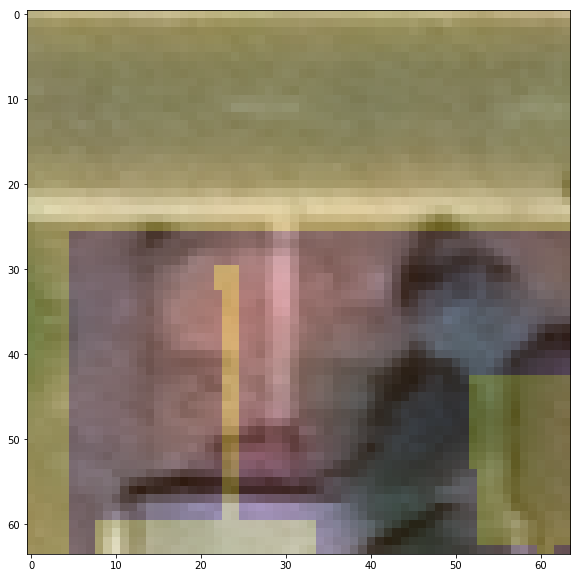

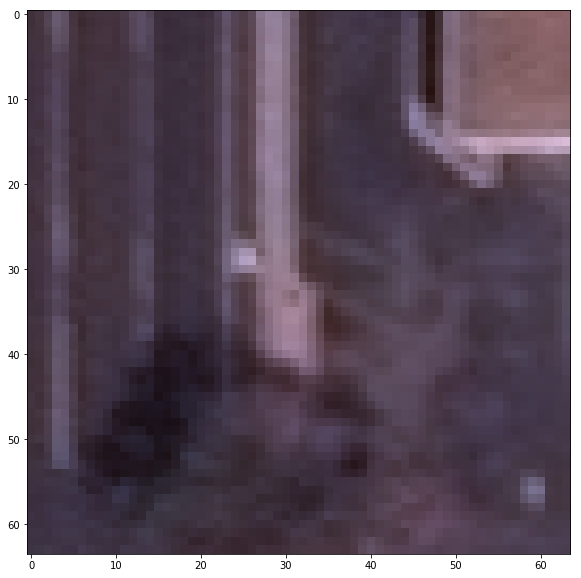

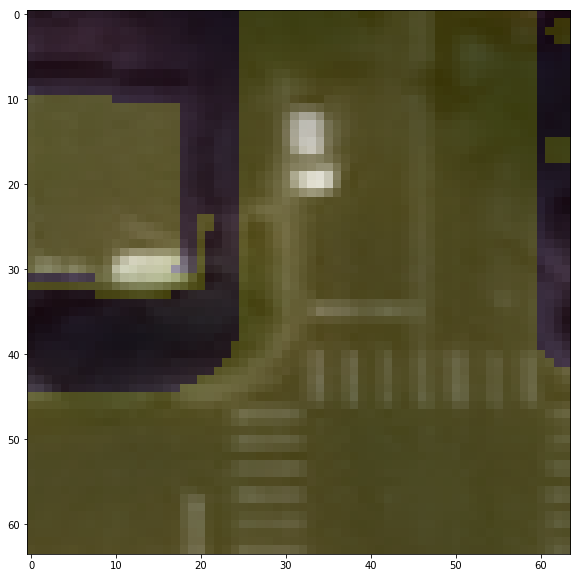

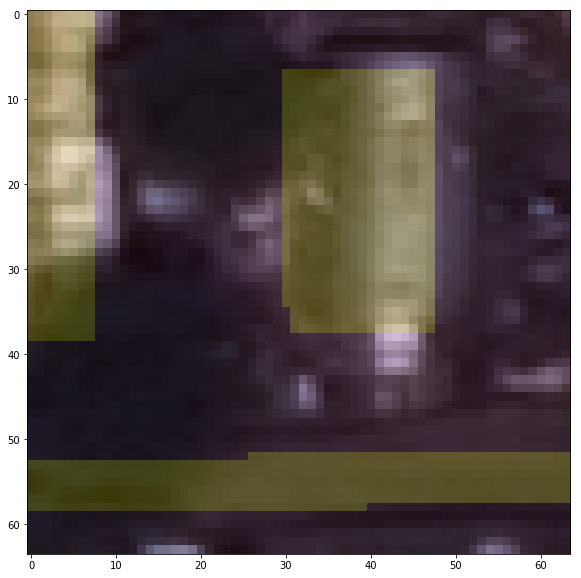

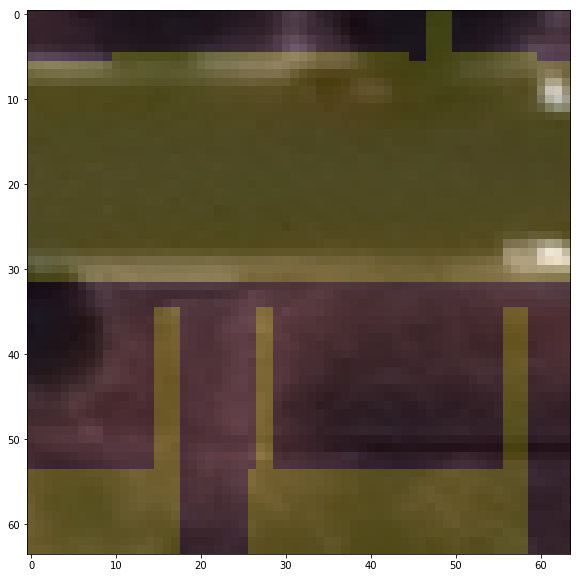

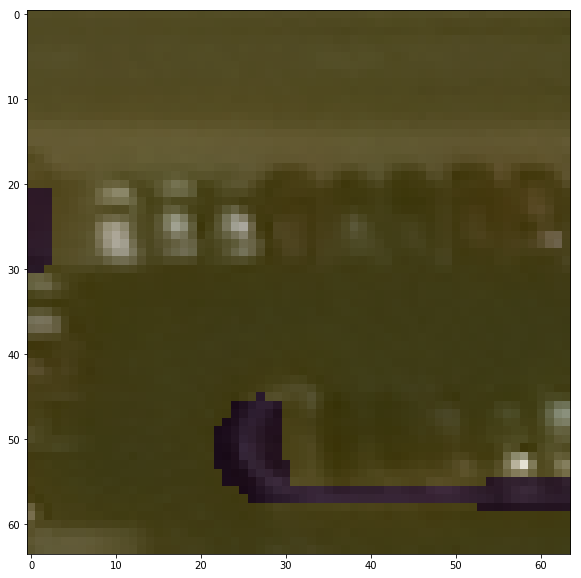

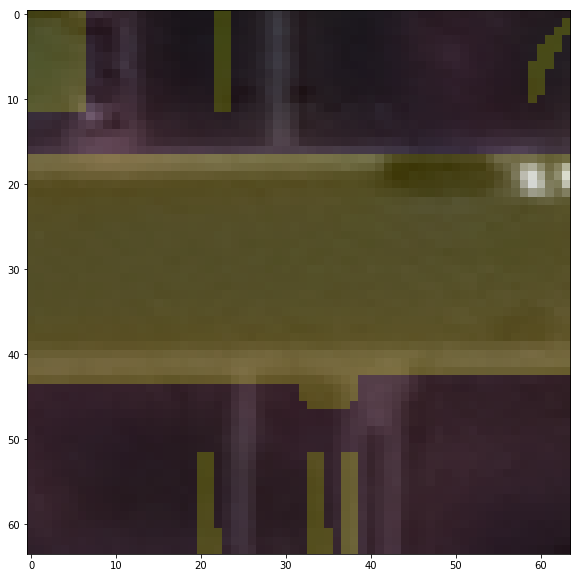

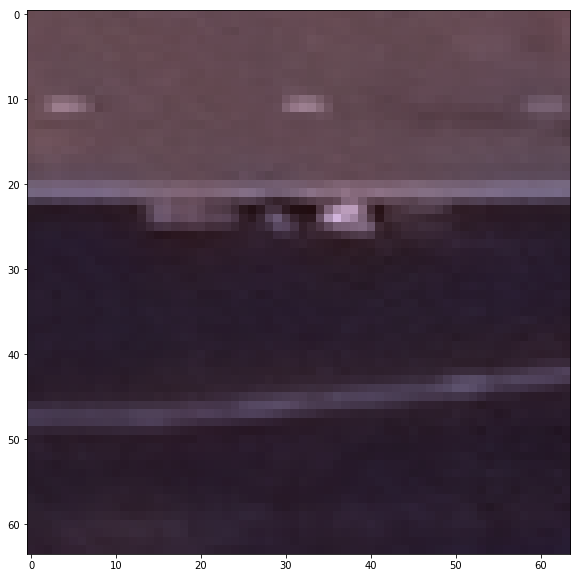

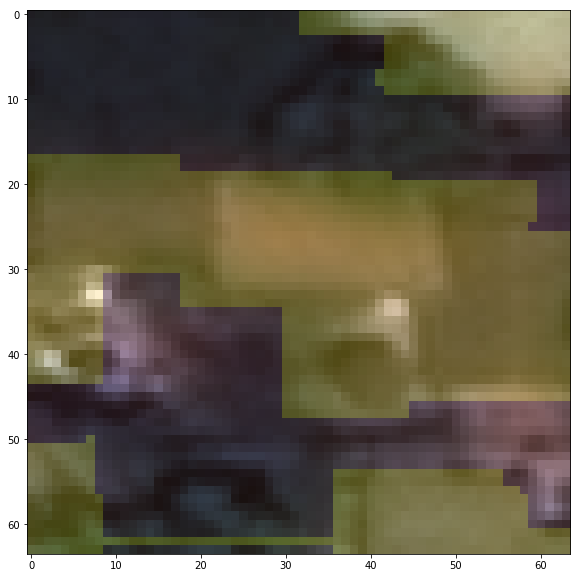

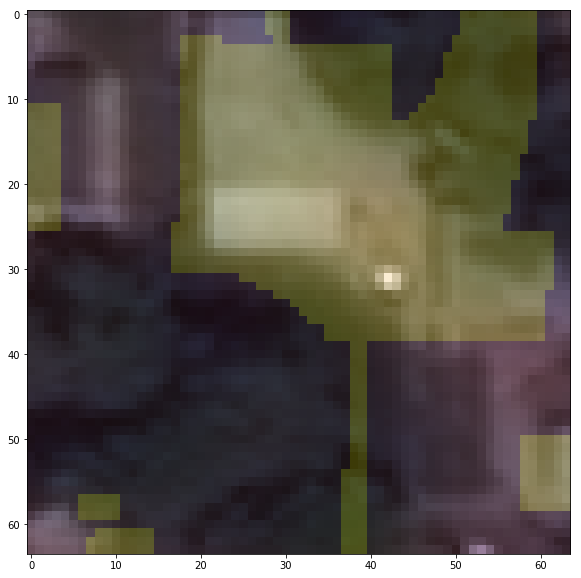

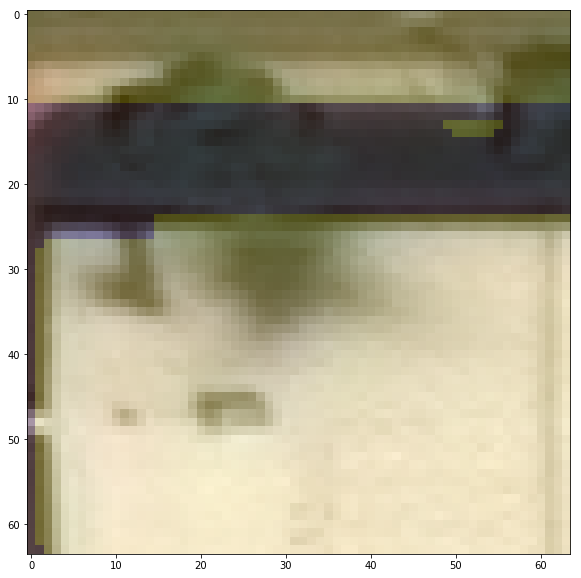

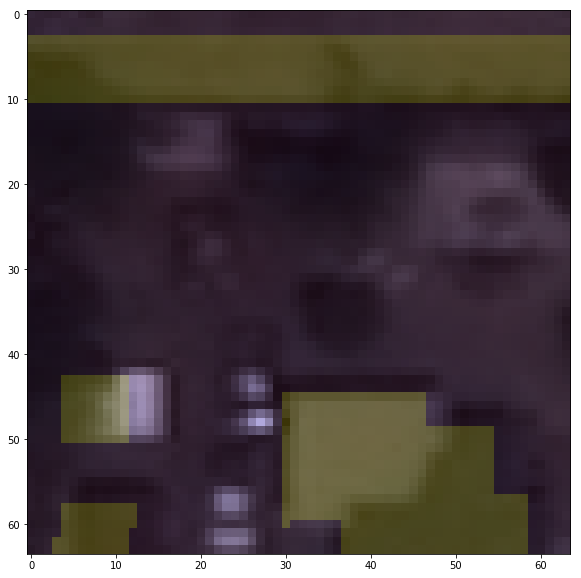

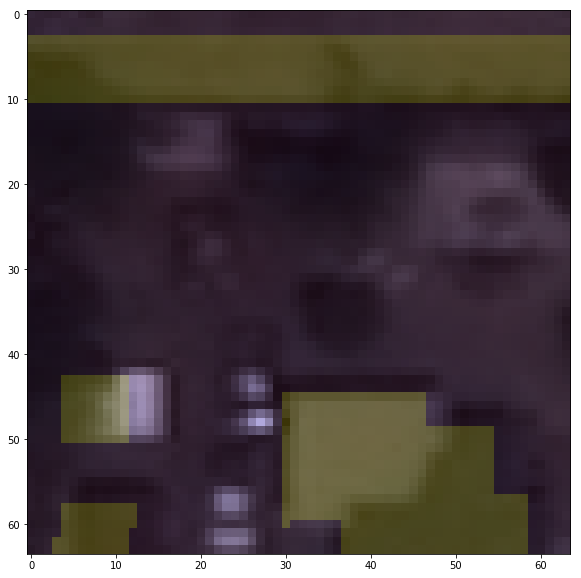

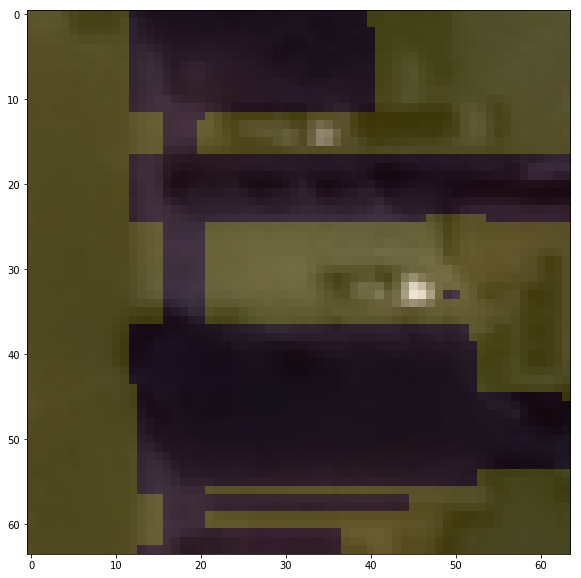

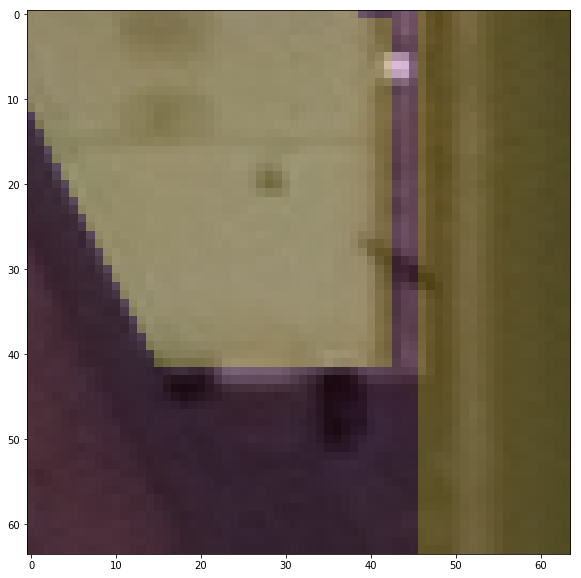

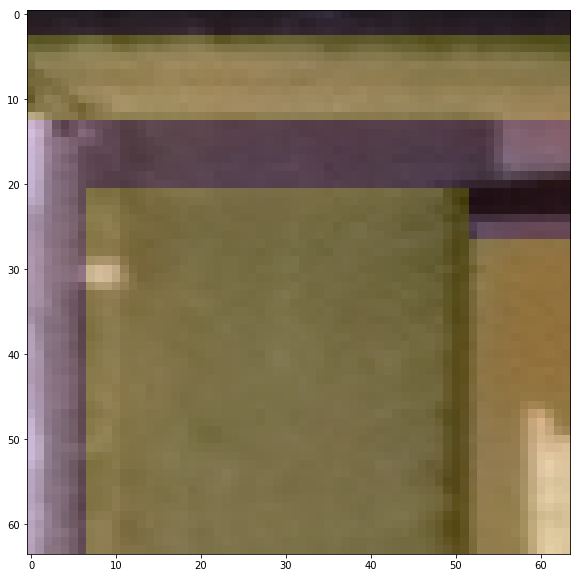

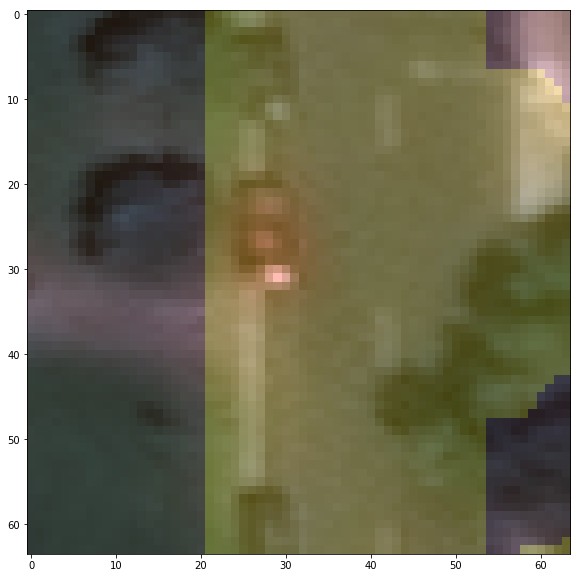

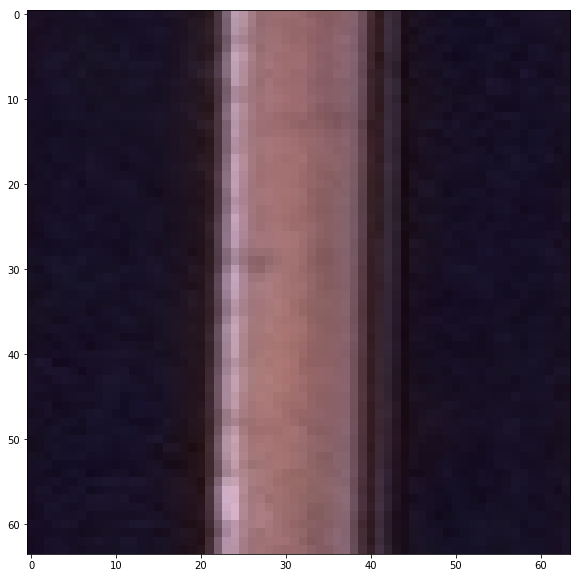

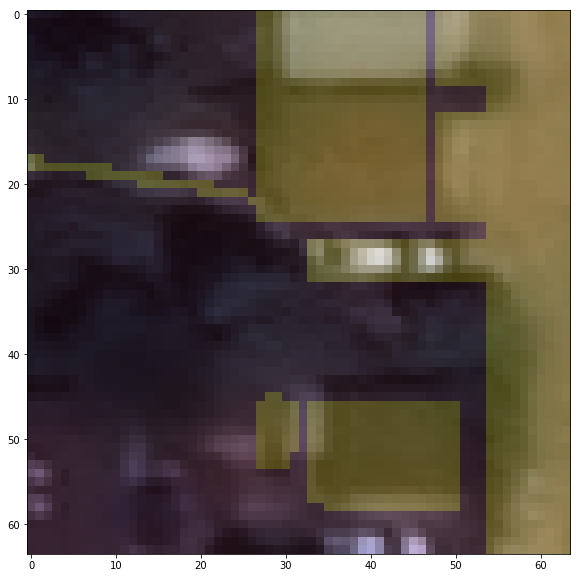

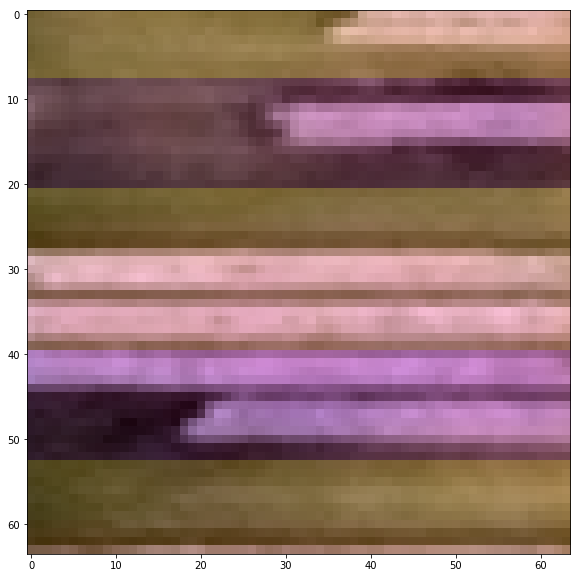

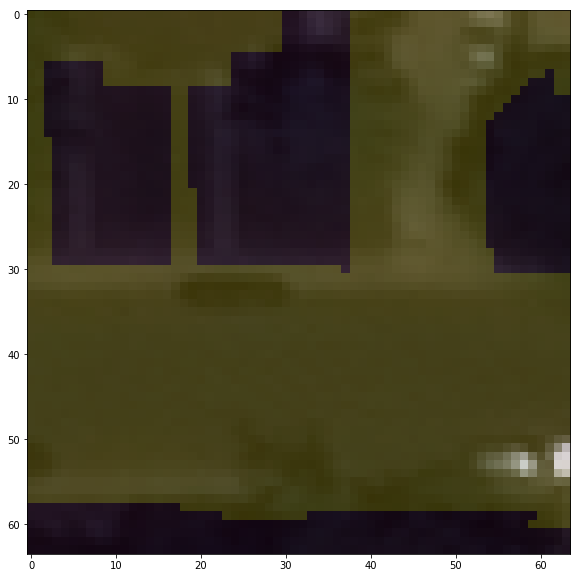

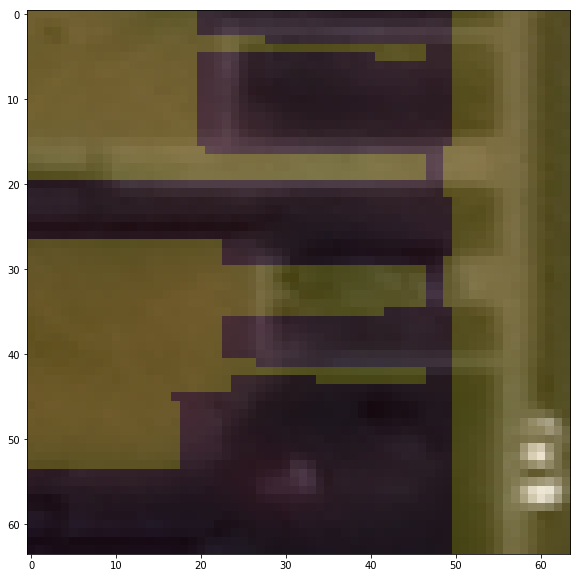

In [41]:
# check one of the test images
gt_image_05 = '../../rasters/union_impervious_raster_0_5_wgs84_SnapR.tif' # desktop
gt_dataset_test = gtDatasetSampler2(gt_image_05, coords_pan[val_ind:], transform=gt_transform, window_size=64)


test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
test_inds = np.random.choice(1000,50)
for test_ind in test_inds:
    
    gt_im = gt_dataset_val[test_ind].numpy().squeeze()
    

    fig = plt.figure(figsize=(10,10))
    source_im = dg_dataset_val[test_ind].numpy()
    source_im = source_im[[2,1,0], :,:]
    plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
    
    plt.imshow(gt_im, alpha=0.2)
    plt.show()



In [32]:
source_im.shape

(4, 64, 64)

In [33]:
gt_im.shape

(64, 64)